<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Modelo de lenguaje con tokenización por palabras
Alumno: Gustavo  Julián Rivas - N°SIU: a1620

### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


In [73]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import gdown
from google.colab import files

### Datos
Para este desafío voy a probar con una publicación del Martín Fierro.

In [74]:
# Descargamos el archivo de mi google Drive
file_id = '1eVvuOwUKZzOhhiMvOzFhmoOB0KOIng30'
destination = 'publicacion-martin-fierro.pdf'


gdown.download(id=file_id, output=destination, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1eVvuOwUKZzOhhiMvOzFhmoOB0KOIng30
To: /content/publicacion-martin-fierro.pdf
100%|██████████| 945k/945k [00:00<00:00, 9.61MB/s]


'publicacion-martin-fierro.pdf'

Para poder extarer la información del pdf utilizamos la librería pymupdf.

In [75]:
# Usamos la libreria pymupdf
!pip install pymupdf

In [76]:
import fitz  # PyMuPDF se importa como 'fitz'

# Ruta del archivo PDF
pdf_path = 'publicacion-martin-fierro.pdf'

# Abre el archivo PDF
doc = fitz.open(pdf_path)

# Extrae el texto de todas las páginas
text = ""
for page_num in range(len(doc)):
    page = doc.load_page(page_num)  # Carga una página
    text += page.get_text()  # Extrae el texto de la página

doc.close()

# Muestra el texto extraído
print(text)

# Convierte el texto en una lista de palabras
texto_extraido = text.split()  # Divide el texto en palabras usando los espacios

# Muestra la lista de palabras
print("Palabras extraídas:")
print(texto_extraido)

José Hernández
El gaucho Martín Fierro
La vuelta de Martín Fierro 
Diseño, compaginación y corrección:
Subdirección Editorial. Biblioteca del Congreso de la Nación
Pasante de corrección: Alexia Erramuspe
© Biblioteca del Congreso de la Nación, 2022
Alsina 1835, CABA
ISBN 978-950-691-129-4
Hernández, José
El gaucho Martín Fierro ; La vuelta de Martín Fierro / José Hernández.
-- Buenos Aires : Biblioteca del Congreso de la Nación, 2022
     262 p. ; 20 cm.
ISBN 978-950-691-129-4
1. Poesía gauchesca. I. Biblioteca del Congreso de la Nación (Argentina), ed.
A 150 años de la primera edición de Martín Fierro de José 
Hernández, la Biblioteca del Congreso publica este texto 
clásico del género gauchesco de la literatura nacional y obra 
fundamental de la cultura argentina.
El presente volumen incluye El gaucho Martín Fierro y La vuel-
ta de Martín Fierro. De la primera se reproduce la edición de 
1978 y de la segunda, la de 1979, en la que Hernández no in-
trodujo variables. Se ha seguido a E

In [77]:
texto_extraido.__len__()

38648

De esta manera tenemos todo el texto y todas las palabras divididas por un espacio.

Ahora tenemos que elegir el tamaño del contexto.


### Elegir el tamaño del contexto

In [78]:
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from tensorflow.keras.preprocessing.text import text_to_word_sequence # equivalente a word_tokenize de nltk
from tensorflow.keras.utils import pad_sequences # se utilizará para padding


A diferencia de lo que se planteo en el ejercicio de clase que estaba separado por versos, necesitamos poder ordenar oraciones en este caso. Para eso vamos a usar la puntuación presente en el documento.

In [79]:
import nltk

# Download the required 'punkt_tab' resource
nltk.download('punkt_tab')

# Ensure 'punkt' is also downloaded, which is often a dependency
nltk.download('punkt')

# Segmentamos el texto en oraciones
sentences = nltk.sent_tokenize(text)  # Usamos NLTK para dividir el texto en oraciones

# Aplicamos 'text_to_word_sequence' para cada oración segmentada
segmented_sentences = [text_to_word_sequence(sentence) for sentence in sentences]

# Muestra las oraciones segmentadas y tokenizadas
print(segmented_sentences)

[['josé', 'hernández', 'el', 'gaucho', 'martín', 'fierro', 'la', 'vuelta', 'de', 'martín', 'fierro', 'diseño', 'compaginación', 'y', 'corrección', 'subdirección', 'editorial'], ['biblioteca', 'del', 'congreso', 'de', 'la', 'nación', 'pasante', 'de', 'corrección', 'alexia', 'erramuspe', '©', 'biblioteca', 'del', 'congreso', 'de', 'la', 'nación', '2022', 'alsina', '1835', 'caba', 'isbn', '978', '950', '691', '129', '4', 'hernández', 'josé', 'el', 'gaucho', 'martín', 'fierro', 'la', 'vuelta', 'de', 'martín', 'fierro', 'josé', 'hernández'], ['buenos', 'aires', 'biblioteca', 'del', 'congreso', 'de', 'la', 'nación', '2022', '262', 'p', '20', 'cm'], ['isbn', '978', '950', '691', '129', '4', '1'], ['poesía', 'gauchesca'], ['i', 'biblioteca', 'del', 'congreso', 'de', 'la', 'nación', 'argentina', 'ed'], ['a', '150', 'años', 'de', 'la', 'primera', 'edición', 'de', 'martín', 'fierro', 'de', 'josé', 'hernández', 'la', 'biblioteca', 'del', 'congreso', 'publica', 'este', 'texto', 'clásico', 'del', 'g

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [80]:
segmented_sentences

[['josé',
  'hernández',
  'el',
  'gaucho',
  'martín',
  'fierro',
  'la',
  'vuelta',
  'de',
  'martín',
  'fierro',
  'diseño',
  'compaginación',
  'y',
  'corrección',
  'subdirección',
  'editorial'],
 ['biblioteca',
  'del',
  'congreso',
  'de',
  'la',
  'nación',
  'pasante',
  'de',
  'corrección',
  'alexia',
  'erramuspe',
  '©',
  'biblioteca',
  'del',
  'congreso',
  'de',
  'la',
  'nación',
  '2022',
  'alsina',
  '1835',
  'caba',
  'isbn',
  '978',
  '950',
  '691',
  '129',
  '4',
  'hernández',
  'josé',
  'el',
  'gaucho',
  'martín',
  'fierro',
  'la',
  'vuelta',
  'de',
  'martín',
  'fierro',
  'josé',
  'hernández'],
 ['buenos',
  'aires',
  'biblioteca',
  'del',
  'congreso',
  'de',
  'la',
  'nación',
  '2022',
  '262',
  'p',
  '20',
  'cm'],
 ['isbn', '978', '950', '691', '129', '4', '1'],
 ['poesía', 'gauchesca'],
 ['i',
  'biblioteca',
  'del',
  'congreso',
  'de',
  'la',
  'nación',
  'argentina',
  'ed'],
 ['a',
  '150',
  'años',
  'de',
  'l

Con las oraciones separadas podemos medir de que tamaño son, es decir cuantas palabras contienen esas oraciones.

In [81]:
# calculamos la longitud de cada secuencia
length_sentences = [len(sentence) for sentence in segmented_sentences]

In [82]:
print(length_sentences)

[17, 41, 13, 7, 2, 9, 35, 15, 24, 25, 11, 39, 30, 33, 27, 31, 33, 31, 22, 9, 29, 37, 31, 34, 5, 29, 31, 35, 34, 35, 29, 29, 32, 30, 31, 20, 9, 32, 29, 25, 31, 29, 34, 31, 2, 8, 22, 24, 28, 30, 5, 20, 7, 30, 16, 11, 32, 30, 10, 16, 57, 13, 16, 61, 12, 32, 32, 22, 11, 29, 5, 31, 29, 19, 11, 7, 21, 20, 11, 34, 30, 30, 36, 33, 12, 23, 6, 3, 21, 30, 31, 10, 9, 8, 32, 31, 28, 19, 1, 8, 30, 14, 19, 32, 25, 13, 27, 27, 30, 23, 5, 28, 29, 29, 30, 32, 33, 32, 29, 32, 31, 9, 18, 27, 27, 10, 10, 10, 26, 8, 22, 8, 8, 2, 7, 11, 17, 12, 21, 10, 8, 9, 33, 29, 31, 21, 1, 11, 31, 34, 32, 29, 28, 20, 10, 32, 29, 30, 35, 18, 10, 26, 27, 29, 36, 26, 3, 14, 10, 28, 34, 31, 28, 29, 29, 13, 19, 21, 13, 34, 36, 31, 31, 35, 30, 4, 7, 21, 32, 26, 29, 27, 28, 33, 29, 11, 8, 10, 26, 15, 17, 33, 13, 7, 8, 37, 30, 8, 22, 10, 10, 14, 24, 11, 34, 29, 35, 10, 20, 35, 32, 28, 25, 26, 29, 23, 1, 8, 23, 11, 31, 28, 29, 33, 32, 34, 30, 11, 9, 11, 11, 9, 12, 29, 27, 0, 0, 0, 30, 26, 31, 9, 22, 39, 35, 11, 23, 28, 27, 33, 31

(array([ 45.,  24.,  58.,  86.,  33.,  75., 122.,  82., 351., 352., 170.,
         42.,  10.,   7.,   3.,   1.,   5.,   6.,   5.,   3.,   1.,   1.,
          0.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   1.,   1.,   0.,   0.,   1.]),
 array([  0.   ,   3.225,   6.45 ,   9.675,  12.9  ,  16.125,  19.35 ,
         22.575,  25.8  ,  29.025,  32.25 ,  35.475,  38.7  ,  41.925,
         45.15 ,  48.375,  51.6  ,  54.825,  58.05 ,  61.275,  64.5  ,
         67.725,  70.95 ,  74.175,  77.4  ,  80.625,  83.85 ,  87.075,
         90.3  ,  93.525,  96.75 ,  99.975, 103.2  , 106.425, 109.65 ,
        112.875, 116.1  , 119.325, 122.55 , 125.775, 129.   ]),
 <BarContainer object of 40 artists>)

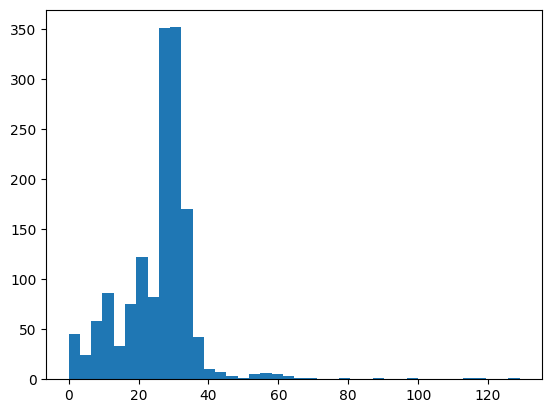

In [83]:
# podemos ver su distribución
plt.hist(length_sentences,bins=40)

Podemos observar que existen algunas oraciones de un tamaño muy superior al resto, nos vamos a quedar con las oraciones mas cortas 100 palabras o menos.

In [84]:
# Filtra las oraciones que tienen 100 palabras o menos
filtered_sentences = [sentence for sentence in segmented_sentences if len(sentence) <= 100]

# Calcula la longitud de cada secuencia en las oraciones filtradas
length_sentences = [len(sentence) for sentence in filtered_sentences]

# Muestra las oraciones filtradas y sus longitudes
print("Oraciones filtradas:", filtered_sentences)
print("Longitudes de oraciones filtradas:", length_sentences)


Oraciones filtradas: [['josé', 'hernández', 'el', 'gaucho', 'martín', 'fierro', 'la', 'vuelta', 'de', 'martín', 'fierro', 'diseño', 'compaginación', 'y', 'corrección', 'subdirección', 'editorial'], ['biblioteca', 'del', 'congreso', 'de', 'la', 'nación', 'pasante', 'de', 'corrección', 'alexia', 'erramuspe', '©', 'biblioteca', 'del', 'congreso', 'de', 'la', 'nación', '2022', 'alsina', '1835', 'caba', 'isbn', '978', '950', '691', '129', '4', 'hernández', 'josé', 'el', 'gaucho', 'martín', 'fierro', 'la', 'vuelta', 'de', 'martín', 'fierro', 'josé', 'hernández'], ['buenos', 'aires', 'biblioteca', 'del', 'congreso', 'de', 'la', 'nación', '2022', '262', 'p', '20', 'cm'], ['isbn', '978', '950', '691', '129', '4', '1'], ['poesía', 'gauchesca'], ['i', 'biblioteca', 'del', 'congreso', 'de', 'la', 'nación', 'argentina', 'ed'], ['a', '150', 'años', 'de', 'la', 'primera', 'edición', 'de', 'martín', 'fierro', 'de', 'josé', 'hernández', 'la', 'biblioteca', 'del', 'congreso', 'publica', 'este', 'texto',

(array([ 53.,  74., 106.,  88., 175., 380., 426., 138.,  12.,   8.,   4.,
          8.,   7.,   2.,   1.,   0.,   1.,   0.,   1.,   1.]),
 array([ 0.  ,  4.85,  9.7 , 14.55, 19.4 , 24.25, 29.1 , 33.95, 38.8 ,
        43.65, 48.5 , 53.35, 58.2 , 63.05, 67.9 , 72.75, 77.6 , 82.45,
        87.3 , 92.15, 97.  ]),
 <BarContainer object of 20 artists>)

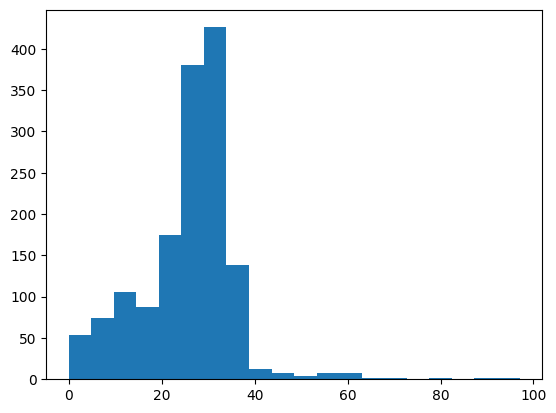

In [85]:
# podemos ver su distribución
plt.hist(length_sentences,bins=20)

De esta manera si parece ser mucho más representativo el estudio.

In [86]:
# a partir de la distribución de longitudes de secuencias elegimos algún criterio
# para determinar el máximo tamaño de contexto. En este caso es un percentil, pero
# otros criterios también pueden ser válidos con la justificación adecuada.
# También puede ser una selección "a mano"

# el -1 es porque el último token será el target
# max_context_size = int(np.percentile(length_sentences, 90)-1)

# max_context_size = int(np.ceil(np.mean(length_sentences))) # criterio de media
max_context_size = int(np.ceil(np.median(length_sentences))) # criterio de mediana
print(f'max_context_size: {max_context_size}')

max_context_size: 28


En este caso se utiliza el criterio de la mediana para elegir el max_context_size que parece ser más adecuado para un libro de texto a la hora de armar una idea.

###  Tokenizar

In [87]:
# instanciamos el tokenizador
tok = Tokenizer()

# El tokenizer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
# El token 0 es reservado y no es asignado. Se utiliza para designar a palabras
# fuera del vocabulario aprendido
tok.fit_on_texts(segmented_sentences)

# Convertimos las palabras a números
# entran palabras -> salen números
tokenized_sentences = tok.texts_to_sequences(segmented_sentences)

In [88]:
tokenized_sentences[0]

[612, 613, 3, 54, 102, 84, 5, 507, 4, 102, 84, 3147, 3148, 2, 1675, 3149, 3150]

In [89]:
segmented_sentences[0]

['josé',
 'hernández',
 'el',
 'gaucho',
 'martín',
 'fierro',
 'la',
 'vuelta',
 'de',
 'martín',
 'fierro',
 'diseño',
 'compaginación',
 'y',
 'corrección',
 'subdirección',
 'editorial']

In [90]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

8215

El tamaño del vocabulario es grande y es posible tener problemas de uso de memoria en GPU, por lo que vamos a reducirlo quedandonos con las palabras más frecuentes.

In [92]:
from collections import Counter

# Cuenta la frecuencia de todas las palabras en los textos tokenizados
word_freq = Counter([word for sentence in tokenized_sentences for word in sentence])

# Define un umbral de frecuencia (e.g., palabras que aparecen menos de 5 veces)
min_freq = 6
reduced_vocab = {word for word, freq in word_freq.items() if freq >= min_freq}

# Crear un nuevo tokenizador con el vocabulario reducido
reduced_vocab_size = len(reduced_vocab)
word_to_index = {word: i+1 for i, word in enumerate(reduced_vocab)}  # Mapear palabras a índices
index_to_word = {i: word for word, i in word_to_index.items()}  # Inverso para decodificar

# Tokeniza las oraciones de nuevo usando solo el vocabulario reducido
tokenized_sentences_reduced = [[word_to_index[word] for word in sentence if word in reduced_vocab]
                               for sentence in tokenized_sentences]


In [27]:
print("Tamaño del vocabulario reducido:", len(word_to_index))


Tamaño del vocabulario reducido: 745


In [93]:
# Definir el límite del vocabulario
max_vocab_size = 1000

# Obtener las `max_vocab_size` palabras más comunes
most_common_words = word_freq.most_common(max_vocab_size)
reduced_vocab = {word for word, freq in most_common_words}

# Crear el nuevo diccionario de índices
word_to_index = {word: i+1 for i, word in enumerate(reduced_vocab)}
index_to_word = {i: word for word, i in word_to_index.items()}

# Tokenizar nuevamente con el vocabulario reducido
tokenized_sentences_reduced = [[word_to_index[word] for word in sentence if word in reduced_vocab]
                               for sentence in tokenized_sentences]

In [48]:
print("Tamaño del vocabulario reducido:", len(word_to_index))


Tamaño del vocabulario reducido: 1000


Lo termino dejando en tan solo 1000 palabras diferentes para poder manejar el espacio en memoria de GPU.

### Organizando y estructurando el dataset

En este punto tenemos en la variable `tokenized_sentences` los versos tokenizados. Vamos a quedarnos con un conjunto de validación que utilizaremos para medir la calidad de la generación de secuencias con la métrica de Perplejidad.

In [94]:
tokenized_sentences_train, tokenized_sentences_val = train_test_split(tokenized_sentences_reduced, test_size=0.2, random_state=42)

Vamos a splitear las oraciones que tienen tamaño mayor al contexto máximo, para generarnos más secuencias de entrenamiento. Mantenemos esta idea ya que el tamaño de contexto máximo no es muy grande.

In [95]:
tok_sent = []

for sent in tokenized_sentences_train:

  # si la secuencia tiene más términos que el tamaño de contexto máximo,
  # armo varias sub-secuencias de tamaño máximo
  if len(sent) > (max_context_size+1):
    extra = len(sent)-(max_context_size+1) + 1
    for i in range(extra):
      tok_sent.append(sent[i:i+max_context_size+1])
  else: # si la secuencia tiene menos términos el tamaño de contexto máximo, dejo la secuencia como está
    tok_sent.append(sent)


In [96]:
len(tok_sent)

1590

In [97]:
tok_sent_augm = []

for sent in tok_sent:

  # generamos todas las sub-secuencias
  subseq = [sent[:i+2] for i in range(len(sent)-1)]
  # en esta línea paddeamos al tamaño de contexto máximo
  tok_sent_augm.append(pad_sequences(subseq, maxlen=max_context_size+1, padding='pre'))


In [98]:
# finalmente concatenamos todas las secuencias en un único array de numpy
train_seqs = np.concatenate(tok_sent_augm, axis=0)
# train_seqs = np.concatenate(tok_sent, axis=0)

In [99]:
train_seqs.shape

(32185, 29)

In [100]:
# y de aquí sacamos las entradas y los targets que consumirá nuestro sistema en
# tiempo de entrenamiento
X = train_seqs[:,:-1]
y = train_seqs[:,1:]

Nótese que estamos estructurando el problema de aprendizaje como *many-to-many*:

Entrada: secuencia de tokens [$x_0$, $x_1$, ..., $x_N$]

Target: secuencia de tokens [$x_1$, $x_2$, ..., $x_{N+1}$]

De manera que la red tiene que aprender que su salida deben ser los tokens desplazados en una posición y un nuevo token predicho (el N+1).

La ventaja de estructurar el aprendizaje de esta manera es que para cada token de target se propaga una señal de gradiente por el grafo de cómputo recurrente, que es mejor que estructurar el problema como *many-to-one* en donde sólo una señal de gradiente se propaga.

In [101]:
# Palabras del vocabulario
tok.index_word

{1: 'que',
 2: 'y',
 3: 'el',
 4: 'de',
 5: 'la',
 6: 'a',
 7: 'en',
 8: 'no',
 9: 'me',
 10: 'se',
 11: 'un',
 12: 'lo',
 13: 'los',
 14: 'con',
 15: 'al',
 16: 'es',
 17: 'como',
 18: 'las',
 19: 'le',
 20: 'por',
 21: 'su',
 22: 'yo',
 23: 'una',
 24: 'más',
 25: 'si',
 26: 'mi',
 27: 'del',
 28: 'ni',
 29: 'sin',
 30: 'pero',
 31: 'cuando',
 32: 'para',
 33: 'ya',
 34: 'era',
 35: 'pues',
 36: 'porque',
 37: 'pa',
 38: 'aunque',
 39: 'he',
 40: 'hombre',
 41: 'ha',
 42: 'siempre',
 43: 'sus',
 44: 'les',
 45: 'hasta',
 46: 'todo',
 47: 'aquel',
 48: 'allí',
 49: 'nos',
 50: 'muy',
 51: 'o',
 52: 'hay',
 53: 'tiene',
 54: 'gaucho',
 55: 'tan',
 56: 'había',
 57: 'ansí',
 58: 'uno',
 59: 'otro',
 60: 'mas',
 61: 'entre',
 62: 'son',
 63: 'todos',
 64: 'qué',
 65: 'mis',
 66: 'cuanto',
 67: 'él',
 68: 'vez',
 69: 'tal',
 70: 'te',
 71: 'ser',
 72: 'esa',
 73: 'dios',
 74: 'después',
 75: 'nunca',
 76: 'indio',
 77: 'dende',
 78: 'naides',
 79: 'este',
 80: 'sé',
 81: 'dos',
 82: 'han'

In [102]:
tokenized_sentences_reduced


[[612, 613, 3, 54, 102, 84, 5, 507, 4, 102, 84, 2],
 [614,
  27,
  746,
  4,
  5,
  747,
  4,
  614,
  27,
  746,
  4,
  5,
  747,
  895,
  613,
  612,
  3,
  54,
  102,
  84,
  5,
  507,
  4,
  102,
  84,
  612,
  613],
 [896, 897, 614, 27, 746, 4, 5, 747, 898],
 [895],
 [],
 [899, 614, 27, 746, 4, 5, 747],
 [6,
  900,
  161,
  4,
  5,
  615,
  4,
  102,
  84,
  4,
  612,
  613,
  5,
  614,
  27,
  746,
  79,
  27,
  4,
  5,
  901,
  2,
  508,
  4,
  5],
 [3, 287, 3, 54, 102, 84, 2, 5, 902, 4, 102, 84],
 [4, 5, 615, 10, 5, 4, 2, 4, 5, 5, 4, 7, 5, 1, 613, 8],
 [10, 41, 6, 7, 18, 5, 4, 18, 15, 51],
 [20, 59, 253, 10, 41, 12, 2, 12],
 [899,
  3,
  54,
  102,
  84,
  102,
  84,
  899,
  156,
  9,
  6,
  118,
  15,
  903,
  4,
  5,
  1,
  3,
  40,
  1,
  12,
  23,
  387,
  17,
  5,
  14,
  3,
  118,
  10],
 [388,
  6,
  13,
  616,
  27,
  192,
  1,
  26,
  617,
  44,
  388,
  7,
  79,
  177,
  1,
  148,
  6,
  118,
  26,
  254,
  9,
  5,
  346,
  2,
  26],
 [618,
  616,
  618,
  63,
  7,
 

In [103]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'que': 1, 'y': 2, 'el': 3, 'de': 4, 'la': 5, 'a': 6, 'en': 7, 'no': 8, 'me': 9, 'se': 10, 'un': 11, 'lo': 12, 'los': 13, 'con': 14, 'al': 15, 'es': 16, 'como': 17, 'las': 18, 'le': 19, 'por': 20, 'su': 21, 'yo': 22, 'una': 23, 'más': 24, 'si': 25, 'mi': 26, 'del': 27, 'ni': 28, 'sin': 29, 'pero': 30, 'cuando': 31, 'para': 32, 'ya': 33, 'era': 34, 'pues': 35, 'porque': 36, 'pa': 37, 'aunque': 38, 'he': 39, 'hombre': 40, 'ha': 41, 'siempre': 42, 'sus': 43, 'les': 44, 'hasta': 45, 'todo': 46, 'aquel': 47, 'allí': 48, 'nos': 49, 'muy': 50, 'o': 51, 'hay': 52, 'tiene': 53, 'gaucho': 54, 'tan': 55, 'había': 56, 'ansí': 57, 'uno': 58, 'otro': 59, 'mas': 60, 'entre': 61, 'son': 62, 'todos': 63, 'qué': 64, 'mis': 65, 'cuanto': 66, 'él': 67, 'vez': 68, 'tal': 69, 'te': 70, 'ser': 71, 'esa': 72, 'dios': 73, 'después': 74, 'nunca': 75, 'indio': 76, 'dende': 77, 'naides': 78, 'este': 79, 'sé': 80, 'dos': 81, 'han': 82, 'fin': 83, 'fierro': 84, 'tanto': 85, 'ese': 86, 'quien': 87, 'esta': 88, 'mesm

In [104]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'hernández': 5, 'vuelta': 6, 'gaucho': 71, 'compaginación': 1, 'fierro': 41, 'el': 755, 'editorial': 1, 'josé': 5, 'martín': 32, 'de': 786, 'subdirección': 1, 'y': 933, 'la': 656, 'corrección': 2, 'diseño': 1, '©': 1, 'isbn': 2, 'caba': 1, 'erramuspe': 1, '691': 2, 'pasante': 1, '978': 2, 'alexia': 1, 'del': 157, 'biblioteca': 5, '129': 3, 'congreso': 4, 'alsina': 1, 'nación': 4, '4': 2, '2022': 2, '950': 4, '1835': 3, 'aires': 4, 'buenos': 4, '262': 2, 'p': 1, '20': 4, 'cm': 1, '1': 3, 'poesía': 1, 'gauchesca': 1, 'ed': 1, 'i': 3, 'argentina': 2, 'género': 2, 'a': 620, '150': 4, 'obra': 7, 'literatura': 4, 'clásico': 1, 'texto': 2, 'años': 21, 'publica': 1, 'gauchesco': 1, 'fundamental': 1, 'primera': 6, 'edición': 2, 'cultura': 2, 'nacional': 3, 'este': 47, 'ta': 4, 'volumen': 1, 'incluye': 1, 'vuel': 1, 'presente': 12, 'se': 443, 'que': 887, 'segunda': 2, 'in': 1, 'reproduce': 1, 'variables': 1, '1978': 1, 'no': 532, 'trodujo': 1, '1979': 1, 'en': 590, 'h


### Definir el modelo

In [105]:
model = Sequential()

# la primera capa es de embedding entrenable. Recordar que se puede variar el tamaño
# del embedding a entrenar
model.add(Embedding(input_dim=max_vocab_size+1, output_dim=16, input_shape=(None,)))

model.add(LSTM(32, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(32, return_sequences=True))
#model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida es del tamaño del vocabulario
model.add(Dense(max_vocab_size+1, activation='softmax'))


# Clasificación multiple categórica --> loss = categorical_crossentropy
# notar que usamos la versión Sparse para utilizar sólo índices en lugar de OHE
model.compile(loss=SparseCategoricalCrossentropy(), optimizer='rmsprop', metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (None, None, 16)            │          16,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, None, 32)            │           6,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, None, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, None, 32)            │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, None, 1001)          │          33,033 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 63,641 (248.60 KB)

 Trainable params: 63,641 (248.60 KB)

 Non-trainable params: 0 (0.00 B)

El modelo resulta bastante simple, una capa de embedding con solo 16 dimensiones, dos capas LSTM y una densa al final para poder hacer la predicción.



Mantenemos el mismo Callback para calcular la perplexity época a época.

In [106]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl, patience=5):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad y la paciencia para detener el entrenamiento.
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.history_ppl = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(len_seq)]
        self.target.extend([seq[i] for i in range(len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save("my_model_word.h5")
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True


### Entrenamiento

In [107]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl = []
hist = model.fit(X, y, epochs=100, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=256)

Epoch 1/100
120/126 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5098 - loss: 5.4975


 mean perplexity: 540.0406840648724 

Saved new model!
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.5108 - loss: 5.4355
Epoch 2/100
120/126 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5316 - loss: 3.1271


 mean perplexity: 430.7314935153941 

Saved new model!
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5316 - loss: 3.1188
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5340 - loss: 2.6781
 mean perplexity: 439.4323414099457 

126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5340 - loss: 2.6778
Epoch 4/100
120/126 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5573 - loss: 2.5795
 mean perplexity: 440.5329367531609 

126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5573 - loss: 2.5791
Epoch 5/100
120/126 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5591 - loss: 2.5551
 mean perplexity: 443.20823092816084 

126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5590 - loss: 2.5554
Epoch 6/100
120/126 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5583 - loss: 2.5487


 mean perplexity: 426.0717970476174 

Saved new model!
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5582 - loss: 2.5489
Epoch 7/100
120/126 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5595 - loss: 2.5325
 mean perplexity: 426.3990817573921 

126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5594 - loss: 2.5329
Epoch 8/100
120/126 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5576 - loss: 2.5315


 mean perplexity: 415.64109537295604 

Saved new model!
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5576 - loss: 2.5311
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5568 - loss: 2.5291
 mean perplexity: 458.3699779046926 

126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5568 - loss: 2.5289
Epoch 10/100
120/126 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5592 - loss: 2.5053


 mean perplexity: 379.3409797690485 

Saved new model!
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5594 - loss: 2.5046
Epoch 11/100
120/126 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5630 - loss: 2.4792
 mean perplexity: 446.3264441537099 

126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5630 - loss: 2.4791
Epoch 12/100
120/126 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5633 - loss: 2.4729
 mean perplexity: 437.21445301321177 

126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5633 - loss: 2.4724
Epoch 13/100
120/126 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5652 - loss: 2.4571


 mean perplexity: 349.10641835147493 

Saved new model!
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5653 - loss: 2.4568
Epoch 14/100
120/126 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5682 - loss: 2.4385
 mean perplexity: 366.463851219065 

126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5682 - loss: 2.4386
Epoch 15/100
120/126 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5662 - loss: 2.4440
 mean perplexity: 398.97242311289057 

126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5664 - loss: 2.4431
Epoch 16/100
120/126 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5718 - loss: 2.4096
 mean perplexity: 392.6896545842978 

126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5717 - loss: 2.4100
Epoch 17/100
120/126 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5705 - loss: 2.4136


 mean perplexity: 342.26251133709343 

Saved new model!
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5705 - loss: 2.4132
Epoch 18/100
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5705 - loss: 2.4063
 mean perplexity: 348.0302885199593 

126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5706 - loss: 2.4061
Epoch 19/100
120/126 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5738 - loss: 2.3805


 mean perplexity: 335.3001229805979 

Saved new model!
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5738 - loss: 2.3808
Epoch 20/100
120/126 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5756 - loss: 2.3699
 mean perplexity: 337.404688855851 

126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5755 - loss: 2.3702
Epoch 21/100
120/126 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5747 - loss: 2.3718
 mean perplexity: 378.8621193923622 

126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5748 - loss: 2.3714
Epoch 22/100
120/126 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5771 - loss: 2.3574
 mean perplexity: 337.1691182698611 

126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5771 - loss: 2.3572
Epoch 23/100
120/126 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5791 - loss: 2.3445


 mean perplexity: 332.33348817565104 

Saved new model!
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5791 - loss: 2.3445
Epoch 24/100
120/126 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5784 - loss: 2.3439
 mean perplexity: 335.3061551472196 

126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5785 - loss: 2.3432
Epoch 25/100
120/126 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5810 - loss: 2.3298


 mean perplexity: 327.3150007687664 

Saved new model!
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5810 - loss: 2.3293
Epoch 26/100
120/126 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5827 - loss: 2.3147
 mean perplexity: 336.0824209486617 

126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5827 - loss: 2.3144
Epoch 27/100
120/126 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5854 - loss: 2.2964
 mean perplexity: 363.2114640180074 

126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5854 - loss: 2.2964
Epoch 28/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5851 - loss: 2.2917


 mean perplexity: 325.203790527394 

Saved new model!
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5851 - loss: 2.2916
Epoch 29/100
120/126 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5878 - loss: 2.2733
 mean perplexity: 417.13716599574116 

126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5878 - loss: 2.2734
Epoch 30/100
120/126 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5883 - loss: 2.2701
 mean perplexity: 325.24076487664706 

126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5884 - loss: 2.2698
Epoch 31/100
120/126 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5907 - loss: 2.2514
 mean perplexity: 368.3280914749846 

126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5907 - loss: 2.2515
Epoch 32/100
120/126 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5896 - loss: 2.2530
 mean perplexity: 397.5040932811432 

126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5897 - loss: 2.2523
Epoch 33/100
120/126 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc

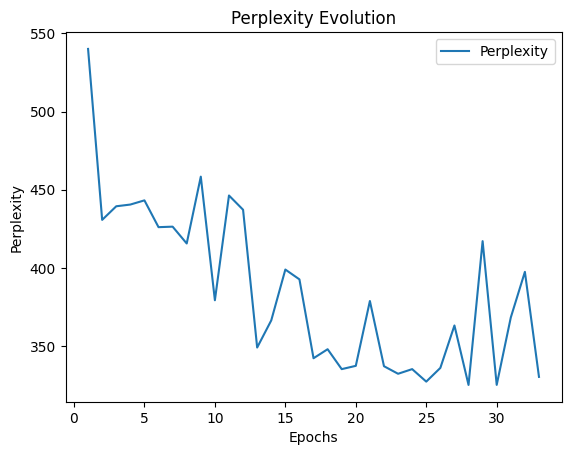

In [108]:
import matplotlib.pyplot as plt
import seaborn as sns

# Podemos graficar la evolución de la perplejidad con las épocas.
# Recordar que el valor de perplejidad del modelo trivial es el tamaño del vocabulario.
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count, y=history_ppl, label='Perplexity')

# Agregar título y etiquetas
plt.title('Perplexity Evolution')
plt.xlabel('Epochs')
plt.ylabel('Perplexity')

# Mostrar leyenda
plt.legend()

# Mostrar gráfico
plt.show()

In [109]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model = keras.models.load_model('my_model_word.h5')

Como era esperable, la perplejidad no evoluciona como sería esperado, sino que parece moverse de manera aleatoria. Esto muy posiblemente se deba a estar usando 10% del total de palabras y que el restante se esté entrenando como una única palabra, a su vez, el modelo tampoco tiene muchos parámetros entrenables y con tan pocas épocas entrenadas el desempeño esperado sería bastante pobre.


### Predicción de próxima palabra

In [110]:
# Se puede usar gradio para probar el modelo
# Gradio es una herramienta muy útil para crear interfaces para ensayar modelos
# https://gradio.app/

!pip install -q gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.7/56.7 MB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.8/319.8 kB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 119.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.3/73.3 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 12.8 MB/s eta 0:00:00


In [111]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = np.argmax(model.predict(encoded)[0,-1,:])


    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://4bbc14c69178af624c.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://4bbc14c69178af624c.gradio.live


Las inferencias usando la api de gradio se pueden ver en las imágenes dentro de esta carpeta.

### Generación de secuencias

In [113]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	  # generate a fixed number of words
    for _ in range(n_words):
		  # Tokenizamos
      encoded = tokenizer.texts_to_sequences([output_text])[0]

		  # Si tienen distinto largo
      encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		  # Predicción softmax
      y_hat = np.argmax(model.predict(encoded)[0,-1,:])

      # Vamos concatenando las predicciones
      out_word = ''

      # Debemos buscar en el vocabulario la palabra
      # que corresopnde al indice (y_hat) predicho por le modelo
      for word, index in tokenizer.word_index.items():
        if index == y_hat:
          out_word = word
          break

		  # Agrego las palabras a la frase predicha
      output_text += ' ' + out_word

    return output_text

In [114]:
input_text='aquí me pongo a cantar'

generate_seq(model, tok, input_text, max_length=max_context_size, n_words=3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


'aquí me pongo a cantar que que el'

In [115]:
input_text='vaca yendo gente al'

generate_seq(model, tok, input_text, max_length=max_context_size, n_words=2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


'vaca yendo gente al del del'

In [116]:
input_text='Yo no soy cantor letrao mas si me pongo a cantar no tengo cuándo acabar y me'

generate_seq(model, tok, input_text, max_length=max_context_size, n_words=10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


'Yo no soy cantor letrao mas si me pongo a cantar no tengo cuándo acabar y me que el de que el de y a la del'

In [117]:
input_text='las coplas me van brotando,'

generate_seq(model, tok, input_text, max_length=max_context_size, n_words=5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


'las coplas me van brotando, el de y a y'

###  Beam search y muestreo aleatorio

In [118]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = tok.texts_to_sequences([text])[0]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return tok.sequences_to_texts([seq])

In [119]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens

In [123]:
# predicción con beam search.
# Se pueden camiar los modos entre 'det' (determinista) y
# 'sto' (estocástico)
# para el caso estocástico también se puede variar la temperatura
salidas = beam_search(model,num_beams=10,num_words=6,input="Me siento en el plan de un bajo a cantar un argumento como ",temp=1,mode='sto')

In [124]:
# tenemos `num_beams` salidas ordenadas de mayor a menor likelihood
salidas.shape

(10, 34)

In [125]:
# veamos las salidas
decode(salidas[0])

['me siento en el plan de un bajo a cantar un argumento como a los que yo no tardanza']

## Conclusiones

Este fue un desafío que realmente me presentó ciertas dificultades. Si bien puede implementar un modelo que pude precedir la siguiente palabra me encontré que siempre me predecía monosilabos, como por ejemplo,"y","que", "de, "el", "a" no logré que prediga un sustantivo probando la visulaización con gradio.

En la parte de generación de secuencia me sucedió algo similar, me generaba una secuencia de monosilabos p.e "el del y a y", " y del y", "que que el"

En el caso del beam search teneniendo en cuenta el parámetro de temperatura en 1 la frase que se completó tuvo un mayor sentido semántico similar a la forma de poema del Martín Fierro.  "a los que yo no tardanza"